In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import control as ct
from control.matlab import *
plt.rcParams['axes.grid'] = True

In [208]:
def getModeloMinimo(p_1: float, p_2: float, p_3: float, g_e: float, i_e: float):
    
    def modeloMinimoStateUpdateFun(t, c, u, params):
        p_1 = params["p_1"]
        p_2 = params["p_2"]
        p_3 = params["p_3"]
        g_e = params["g_e"]
        i_e = params["i_e"]
        
        c_constrained = np.clip(c, [0, 0], [sys.float_info.max, sys.float_info.max])
        u_constrained = np.clip(u, i_e, sys.float_info.max)
        
        dc_0 = -p_1*c_constrained[0] + c_constrained[1]*c[0] + p_1*g_e
        dc_1 = -p_2*c_constrained[1] + p_3*(u_constrained[0]-i_e)
        
        dc_dt = np.array([dc_0, dc_1]).reshape(-1)
        return dc_dt
    
    def modeloMinimoStateOutputFun(t, c, u, params):
        return c
    
    params_dict = {
        "p_1": p_1,
        "p_2": p_2,
        "p_3": p_3,
        "g_e": g_e,
        "i_e": i_e
    }
    
    system = ct.NonlinearIOSystem(
        updfcn = modeloMinimoStateUpdateFun,
        outfcn = modeloMinimoStateOutputFun,
        inputs = ["u"],
        outputs = ["c_g", "c_i"],
        states = ["c_g", "c_i"],
        dt = 0,
        name = "Modelo Mínimo",
        params = params_dict
    )
    
    return system

In [213]:
parametros_normais = {
    "p_1": 1,
    "p_2": 1,
    "p_3": 1,
    "g_e": .85,
    "i_e": .4
}

dinamicaNormal = getModeloMinimo(**parametros_normais)

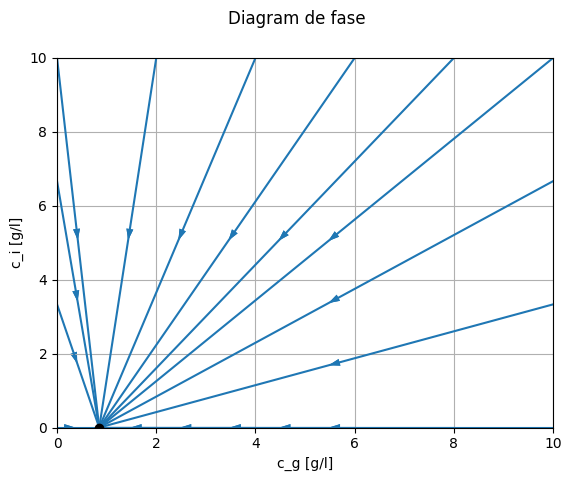

In [216]:
phase_plote_boundries = [0.0, 10, 0.0, 10]
fig = plt.figure()

streamlines = ct.phase_plane_plot(dinamicaNormal, 
                    pointdata=phase_plote_boundries,
                    timedata=1800,
                    plot_streamlines=True,
                    plot_equilpoints=True,
                    plot_vectorfield=False,
                    plot_separatrices=False)    
plt.suptitle(f"Diagrama de fase")
plt.ylabel("c_i [g/l]")
plt.xlabel("c_g [g/l]")

plt.show()


In [197]:
linspace(0,1,10).shape

(10,)

In [198]:
def simulate_system(model: ct.InputOutputSystem, initial_state, insulinInput, elapsedTime = 180):
    time = np.linspace(0,elapsedTime,elapsedTime)
    response = ct.input_output_response(model, T=time, U=insulinInput, X0=initial_state, return_x=True)
    return response, time

def simulate_step(model: ct.InputOutputSystem, initial_state, amplitude = 5, elapsedTime = 180):
    insulinInput =  amplitude*np.ones(shape=(elapsedTime,))
    return simulate_system(model, initial_state, insulinInput, elapsedTime)

def simulate_degrau_finito(model: ct.InputOutputSystem, initial_state, amplitude = 5, duration=3, elapsedTime = 3600):
    insulinInput = np.zeros(shape=(elapsedTime,))
    insulinInput[0:duration] = amplitude
    return simulate_system(model, initial_state, insulinInput, elapsedTime)

In [199]:
initial_state = [0, 0]
equilibrium_state = [parametros_normais["g_e"], 0]

stepAmpliteude = 1
elapsedTime=180

stepResponse, time = simulate_step(dinamicaNormal, equilibrium_state, stepAmpliteude, elapsedTime=elapsedTime)

In [200]:
def plot_state_trajectory(reponse: ct.timeresp.TimeResponseData):    
    fig = plt.figure()
    c_g = reponse.outputs[0]
    c_i = reponse.outputs[1]
    plt.plot(c_g, c_i, "-")
    plt.xlabel(r"c_g [g/l]")
    plt.ylabel(r"c_i [g/l]")
    

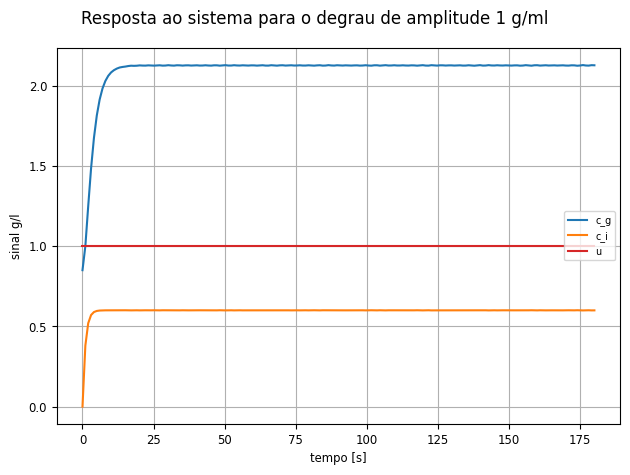

In [218]:
fig = plt.figure()
step_plots = ct.time_response_plot(stepResponse, overlay_traces=True, overlay_signals=True, plot_inputs='overlay')

fig.suptitle(f"Resposta ao sistema para o degrau de amplitude {stepAmpliteude} g/ml")
for ax in fig.axes:
    ax.grid(visible=True)
    ax.set_ylabel('sinal g/l')

plt.xlabel("tempo [s]")

plt.show()

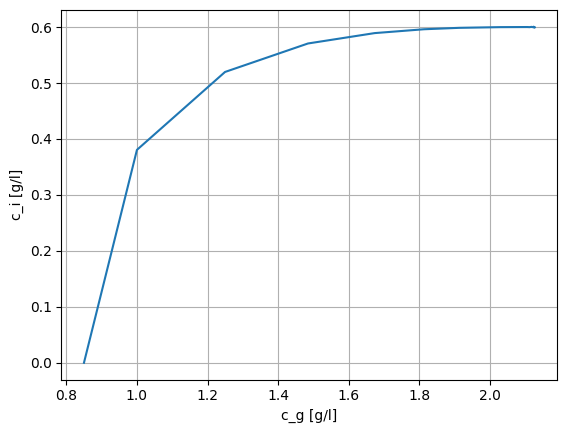

In [183]:
plot_state_trajectory(stepResponse)